In [1]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

In [15]:
# ==========================================
# CẤU HÌNH
# ==========================================
CASCADE_PATH = r'D:\Projects\EmotionDetection\LearnData\Output\haarcascade_frontalface_default.xml'
MODEL_PATH = r'D:\Projects\EmotionDetection\LearnData\model\Best_Emotion_MobileNetV2.keras'

# Đường dẫn ảnh bạn muốn test
IMAGE_PATH = r'D:\Projects\EmotionDetection\LearnData\Output\image_happy.jpg'  # <--- Thay ảnh của bạn vào đây

CLASS_LABELS = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

In [12]:
def preprocess_roi(roi, target_h, target_w, target_c):
    if roi is None or roi.size == 0:
        return None

    # 1. Resize
    roi_resized = cv2.resize(roi, (target_w, target_h), interpolation=cv2.INTER_AREA)

    # 2. Chuyển sang RGB (MobileNetV2 cần RGB)
    if target_c == 3:
        if roi_resized.ndim == 2:
            roi_resized = cv2.cvtColor(roi_resized, cv2.COLOR_GRAY2RGB)
        else:
            roi_resized = cv2.cvtColor(roi_resized, cv2.COLOR_BGR2RGB)
    
    # 3. Chuẩn hóa [-1, 1]
    arr = roi_resized.astype('float32')
    arr = preprocess_input(arr)
    return np.expand_dims(arr, axis=0)

In [16]:
def main():
    # Kiểm tra tồn tại file
    if not os.path.exists(CASCADE_PATH): return print(f"Thiếu file: {CASCADE_PATH}")
    if not os.path.exists(MODEL_PATH): return print(f"Thiếu file: {MODEL_PATH}")
    if not os.path.exists(IMAGE_PATH): return print(f"Không tìm thấy ảnh: {IMAGE_PATH}")

    print("Loading model...")
    face_cascade = cv2.CascadeClassifier(CASCADE_PATH)
    model = load_model(MODEL_PATH, compile=False)

    # Lấy kích thước input model
    try:
        in_shape = model.input_shape
        H, W, C = in_shape[1], in_shape[2], in_shape[3]
    except:
        H, W, C = 224, 224, 3

    # Đọc ảnh
    img = cv2.imread(IMAGE_PATH)
    if img is None: return print("Lỗi đọc ảnh!")
    
    # Copy để vẽ lên
    output_img = img.copy()
    
    # Phát hiện khuôn mặt
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    print(f"Tìm thấy {len(faces)} khuôn mặt.")

    for (x, y, w_box, h_box) in faces:
        # Cắt vùng mặt (ROI) từ ảnh gốc màu
        roi = img[y:y + h_box, x:x + w_box]

        try:
            inp = preprocess_roi(roi, H, W, C)
            if inp is not None:
                # Dự đoán
                preds = model.predict(inp, verbose=0)[0]
                idx = np.argmax(preds)
                label = CLASS_LABELS[idx]
                prob = preds[idx]

                # Màu sắc (BGR cho OpenCV)
                if label == 'Angry': color = (0, 0, 255)       # Đỏ
                elif label == 'Happy': color = (0, 255, 0)     # Xanh lá
                elif label == 'Sad': color = (255, 0, 0)       # Xanh dương
                else: color = (0, 255, 255)                    # Vàng

                # Vẽ khung và chữ
                cv2.rectangle(output_img, (x, y), (x + w_box, y + h_box), color, 2)
                
                # Tạo nền chữ đen để dễ đọc
                text_label = f"{label}: {prob*100:.1f}%"
                (text_w, text_h), _ = cv2.getTextSize(text_label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
                cv2.rectangle(output_img, (x, y - 35), (x + text_w, y), color, -1)
                cv2.putText(output_img, text_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

        except Exception as e:
            print(f"Lỗi xử lý mặt: {e}")

    # Hiển thị ảnh kết quả bằng Matplotlib (để hiện đúng màu trong Notebook/IDE)
    # Vì OpenCV dùng BGR, Matplotlib dùng RGB nên cần chuyển đổi lại
    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Ket qua du doan")
    plt.show()
    
    # Nếu muốn lưu ảnh ra file
    # cv2.imwrite('result_image_happy.jpg', output_img)
    # print("Đã lưu ảnh kết quả thành 'result_image.jpg'")

Loading model...
Tìm thấy 1 khuôn mặt.


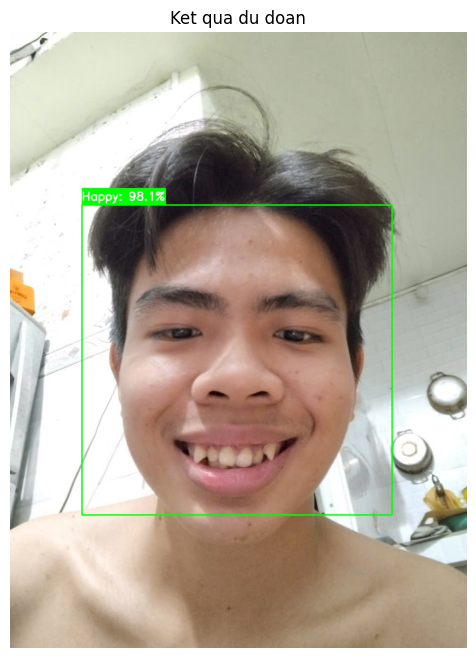

In [17]:
if __name__ == '__main__':
    main()